<a href="https://colab.research.google.com/github/Elpastore/vector_analysis/blob/main/GWSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq malariagen_data
import malariagen_data
import numpy as np
import pandas as pd
import allel
import zarr
import matplotlib.pyplot as plt
import seaborn as sns

ag3 = malariagen_data.Ag3()
ag3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release_master_us_central1/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.10, 3.11, 3.12, 3.13, 3.14
Results cache           : None
Cohorts analysis        : 20250502
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 15.2.2
Client location         : Nevada, United States (Google Cloud us-west4)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.2.2/Ag3.html

## Functions for GWSS

In [ ]:
def run_gwss(cohort, contig, window_size):
  """
  function that compute H12 value for a given cohort and contig
  """
  pos, h12, contigs = ag3.h12_gwss(
      contig=contig,
      sample_query=f"country=='Gambia, The' and taxon == '{cohort}'",
      window_size=window_size,
      #analysis="gamb_colu_arab",
      analysis="arab",
      min_cohort_size=10,
      max_cohort_size=100,
      )
  return pos, h12, contigs # x: ndarray h12: ndarray

def find_best_window_size(contig, cohort=None):
    """
    Function to compute the best window size for H12 calculation based on the rule:
    Choose the smallest window size where the 95th percentile of H12 values is within a specified range.

    Parameters:
        contig (str): The contig (chromosome) name.
        cohort (str): The cohort (taxon) name.

    Returns:
        int: The best window size.
    """
    try:
        # Compute H12 calibration for the given cohort and contig
        h12_cal = ag3.h12_calibration(
            contig=contig,
            sample_query=f"country=='Gambia, The' and taxon == '{cohort}'",
            #analysis="gamb_colu_arab",
            analysis="arab",
            max_cohort_size=100,
        )

        if not h12_cal:
            print("No H12 calibration data found.")
            return None

        # Extract window sizes and compute percentiles
        window_sizes = [int(w) for w in h12_cal.keys()]
        q95_values = [np.percentile(h12_cal[str(window)], 95) for window in window_sizes]

        # Find all valid window sizes where 95th percentile is within the range
        valid_windows = {
            window: q95 for window, q95 in zip(window_sizes, q95_values) if 0.03 <= q95 < 0.08
        }

        # Prioritize Q95 in the range [0.04-0.05]
        if valid_windows:
            sorted_valid_windows = sorted(valid_windows.items(), key=lambda x: x[0])  # Sort by window size
            for window, q95 in sorted_valid_windows:
                if 0.04 <= q95 <= 0.05:
                    print(f"Window size returned: {window}, Q95: {q95:.3f}")
                    return window

            # If no window within [0.04-0.05], take the smallest valid window
            print("No value found in the range [0.04-0.05]. Choosing smallest valid window.")
            #best_window_size = min(valid_windows.keys())
            # Use input to pick the optimal windows size?
            #print(f"Window size returned: {best_window_size}, Q95: {valid_windows[best_window_size]:.3f}")
            print("Remaining window sizes:")
            for window, q95 in valid_windows.items():
                #if window != best_window_size:
                print(f"Window size: {window}, Q95: {q95:.3f}")
            print('------------------------------------')
            others_window_size = {window: q95 for window, q95 in zip(window_sizes, q95_values) if q95 < 0.1}
            print("Complete list of window sizes:")
            for window, q95 in others_window_size.items():
                print(f"Window size: {window}, Q95: {q95:.3f}")
            optimal_window_size = input("Enter the optimal window size based on the Q95: \n")
            best_window_size = int(optimal_window_size)
            return best_window_size

        else:
            new_valid_window_size =  {
            window: q95 for window, q95 in zip(window_sizes, q95_values) if q95 < 0.1
        }
            # If no valid windows, choose the one with the smallest Q95
            min_q95_idx = np.argmin(q95_values)
            best_window_size = window_sizes[min_q95_idx]
            print(f"No valid window size found. Returning window size with minimum Q95: "
                  f"{best_window_size}, Q95: {q95_values[min_q95_idx]:.3f}")
            print("Remaining window sizes:")
            for window, q95 in new_valid_window_size.items():
                if window != best_window_size:
                    print(f"Window size: {window}, Q95: {q95:.3f}")
            # Confirm the window size
            choice = input("Is this the optimal window size? (y/n): ")
            if (not isinstance(choice, str)):
              print("Invalid input. Please enter 'y' or 'n'.")
              choice = input()
            if choice.lower() == 'y':
              return best_window_size
            else:
              print("Please enter the optimal window size:")
              optimal_window_size = input()
              best_window_size = int(optimal_window_size)
              return best_window_size

    except Exception as e:
        print(f"Error during computation: {e}")
        return None



# FInd GEnes in a range of region for specif region
def locate_snp_in_region(contig, dataframe):
  """
  function that locate SNP in a given region
  """
  genes_list = (
    ag3.genome_features(region=contig).query("type=='gene'")
    [["contig", "type", "ID", "start", "end", "Name", "description"]]
    .set_index("ID")
  )
  features_df = pd.DataFrame()

  for idx, row in dataframe.iterrows():
      # Query the features DataFrame
      features = genes_list.query(f"start <= {row['Chr_pos']} and end >= {row['Chr_pos']}")

      # Proceed only if features is not empty
      if not features.empty:
          # Create a copy to avoid SettingWithCopyWarning
          features = features.copy()

          # Add 'Chr_pos' and 'ihs' columns explicitly
          features['Chr_pos'] = row['Chr_pos']
          features['ihs'] = row['ihs']

          # Concatenate to the final DataFrame with multi-index
          features_df = pd.concat([features_df, features.set_index(['Chr_pos', features.index])])

  # Display the final DataFrame
  return features_df


In [ ]:
##GWSS with H12 by  cohort
def run_gwss_by_cohort(taxon , cohort_group, cohort, country ,contig, window_size):
  """
  function that compute H12 value for a given cohort and contig
  """
  try:
    pos, h12, contigs = ag3.h12_gwss(
        contig=contig,
        sample_query=f"country=='{country}' and taxon=='{taxon}' and {cohort_group} == '{cohort}'",
        window_size=window_size,
        analysis="gamb_colu",
        min_cohort_size=10,
        max_cohort_size=100,
        )
    return pos, h12, contigs # x: ndarray h12: ndarray
  except Exception as e:
    print(f"Error during computation: {e}")
    return None
def find_best_window_size_by_cohort(contig, taxon, country, cohort_group, cohort):
    """
    Function to compute the best window size for H12 calculation based on the rule:
    Choose the smallest window size where the 95th percentile of H12 values is within a specified range.

    Parameters:
        contig (str): The contig (chromosome) name.
        cohort (str): The cohort (taxon) name.

    Returns:
        int: The best window size.
    """
    try:
        # Compute H12 calibration for the given cohort and contig
        h12_cal = ag3.h12_calibration(
            contig=contig,
            sample_query=f"country=='{country}' and taxon=='{taxon}' and {cohort_group} == '{cohort}'",
            analysis="gamb_colu",
            min_cohort_size=10,
            max_cohort_size=100,
        )

        if not h12_cal:
            print("No H12 calibration data found.")
            return None

        # Extract window sizes and compute percentiles
        window_sizes = [int(w) for w in h12_cal.keys()]
        q95_values = [np.percentile(h12_cal[str(window)], 95) for window in window_sizes]

        # Find all valid window sizes where 95th percentile is within the range
        valid_windows = {
            window: q95 for window, q95 in zip(window_sizes, q95_values) if 0.03 <= q95 < 0.08
        }

        # Prioritize Q95 in the range [0.04-0.05]
        if valid_windows:
            sorted_valid_windows = sorted(valid_windows.items(), key=lambda x: x[0])  # Sort by window size
            for window, q95 in sorted_valid_windows:
                if 0.04 <= q95 <= 0.05:
                    print(f"Window size returned: {window}, Q95: {q95:.3f}")
                    return window

            # If no window within [0.04-0.05], take the smallest valid window
            print("No value found in the range [0.04-0.05]. Choosing smallest valid window.")
            #best_window_size = min(valid_windows.keys())
            # Use input to pick the optimal windows size?
            #print(f"Window size returned: {best_window_size}, Q95: {valid_windows[best_window_size]:.3f}")
            print("Remaining window sizes:")
            for window, q95 in valid_windows.items():
                #if window != best_window_size:
                print(f"Window size: {window}, Q95: {q95:.3f}")
            print('------------------------------------')
            others_window_size = {window: q95 for window, q95 in zip(window_sizes, q95_values) if q95 < 0.1}
            print("Complete list of window sizes:")
            for window, q95 in others_window_size.items():
                print(f"Window size: {window}, Q95: {q95:.3f}")
            optimal_window_size = input("Enter the optimal window size based on the Q95: \n")
            best_window_size = int(optimal_window_size)
            return best_window_size

        else:
            new_valid_window_size =  {
            window: q95 for window, q95 in zip(window_sizes, q95_values) if q95 < 0.1
        }
            # If no valid windows, choose the one with the smallest Q95
            min_q95_idx = np.argmin(q95_values)
            best_window_size = window_sizes[min_q95_idx]
            print(f"No valid window size found. Returning window size with minimum Q95: "
                  f"{best_window_size}, Q95: {q95_values[min_q95_idx]:.3f}")
            print("Remaining window sizes:")
            for window, q95 in new_valid_window_size.items():
                if window != best_window_size:
                    print(f"Window size: {window}, Q95: {q95:.3f}")
            # Confirm the window size
            choice = input("Is this the optimal window size? (y/n): ")
            if (not isinstance(choice, str)):
              print("Invalid input. Please enter 'y' or 'n'.")
              choice = input()
            if choice.lower() == 'y':
              return best_window_size
            else:
              print("Please enter the optimal window size:")
              optimal_window_size = input()
              best_window_size = int(optimal_window_size)
              return best_window_size

    except Exception as e:
        print(f"Error during computation: {e}")
        return None

In [ ]:
def sorted_H12_data(H12_taxon_cohort_data):
  """
  function to sort iHs data by cohort and year
  """
  # Extract the year from Cohort column
  H12_taxon_cohort_data['Year'] = H12_taxon_cohort_data['Cohort'].str.extract(r'_(\d{4})$', expand=False).astype(int)
  #Extract the region (e.g., GM-M, GM-N, GM-W) from the 'Cohort' column
  H12_taxon_cohort_data['Region'] = H12_taxon_cohort_data['Cohort'].str.extract(r'^(GM-[A-Z])_', expand=False)
  # stor the data by region and year
  H12_taxon_cohort_data_sorted = H12_taxon_cohort_data.sort_values(by=['Year', 'Region'], ascending=[True, True])

  return H12_taxon_cohort_data_sorted

## GWSS by region

In [ ]:
# Contigs and cohorts setup
contigs = ["2L","2R", "3L","3R", "X"]
taxon = 'coluzzii'
country = 'Gambia, The'


ihs_final_df = pd.DataFrame()
list_cohort_group = ['country_iso', 'admin1_name', 'admin1_iso', 'admin2_name', 'cohort_admin1_year']
print("cohort group list:")
for i in list_cohort_group:
  print(i)
cohort_group = input("Enter the cohort group to use: ")
if cohort_group not in list_cohort_group or cohort_group is None:
  print("Invalid cohort group. Please choose from the list.")
  cohort_group = input("Enter the cohort group to use: ")


# Let's use cohorts with at least 30 samples for good resutl
size_info = ag3.sample_metadata(sample_query=f"taxon=='{taxon}' and country=='Gambia, The'").groupby(f'{cohort_group}').size().reset_index()
size_info.columns = [cohort_group, 'size']
cohorts = []
for index, row in size_info.iterrows():
  if row['size'] >= 10:
    cohorts.append(row[f'{cohort_group}'])
    print(f"{row[cohort_group]}: {row['size']}")
cohorts


# Initialize an empty DataFrame to store results
final_h12_df = pd.DataFrame()



# Initialize a temporary list to collect results for the cohort
cohort_results = []
cohort = input("Enter the cohort to use: ")
print(f"Processing cohort: {cohort}")
for contig in contigs:
    print(f"  Processing contig: {contig}")

    # Find the best window size
    try:
        window_size = find_best_window_size_by_cohort(contig, taxon, country, cohort_group, cohort)
        print(f"  Best window size: {window_size}")
    except Exception as e:
        print(f"  Error finding window size for {contig}, {cohort}: {e}")
        continue

    # Run the genome-wide scan for selection (GWSS)
    try:
        pos, h12, contigs = run_gwss_by_cohort(taxon , cohort_group, cohort, country ,contig, window_size)
        cohort_results.append({
            "chrom": contig,
            "Chr_pos": pos,  # Chromosomal positions
            "H12": h12,      # H12 values
            "window_size": window_size  # Window size used
        })
    except Exception as e:
        print(f"  Error running GWSS for {contig}, {cohort}: {e}")
        continue

# Process results for the current cohort and append to the final DataFrame
for result in cohort_results:
    temp_df = pd.DataFrame({
        "Chr_pos": result["Chr_pos"],
        "H12": result["H12"],
        "Cohort": cohort,
        "chrom": result["chrom"],
        "window_size": result["window_size"]
    })
    final_h12_df = pd.concat([final_h12_df, temp_df], ignore_index=True)

print("H12 selection scan complete.")
#final_h12_df.to_csv(f'{taxons}_h12_GWSS_results.csv', index=False)
final_h12_df.to_csv(f'{taxon}_{cohort}_h12_GWSS_results.csv', index=False)


cohort group list:
country_iso
admin1_name
admin1_iso
admin2_name
cohort_admin1_year
Enter the cohort group to use: admin1_iso
GM-L: 26
GM-M: 636
GM-N: 31
GM-U: 171
GM-W: 20
Enter the cohort to use: GM-W
Processing cohort: GM-W
  Processing contig: 2L


Load haplotypes:   0%|          | 0/798 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/8 [00:00<?, ?it/s]

Window size returned: 5000, Q95: 0.044
  Best window size: 5000


Load haplotypes:   0%|          | 0/798 [00:00<?, ?it/s]

  Processing contig: 2R


Load haplotypes:   0%|          | 0/966 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/8 [00:00<?, ?it/s]

Window size returned: 2000, Q95: 0.049
  Best window size: 2000


Load haplotypes:   0%|          | 0/966 [00:00<?, ?it/s]

  Processing contig: 3L


Load haplotypes:   0%|          | 0/616 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/8 [00:00<?, ?it/s]

No value found in the range [0.04-0.05]. Choosing smallest valid window.
Remaining window sizes:
Window size: 2000, Q95: 0.058
Window size: 5000, Q95: 0.039
Window size: 10000, Q95: 0.033
------------------------------------
Complete list of window sizes:
Window size: 1000, Q95: 0.093
Window size: 2000, Q95: 0.058
Window size: 5000, Q95: 0.039
Window size: 10000, Q95: 0.033
Window size: 20000, Q95: 0.029
Enter the optimal window size based on the Q95: 
5000
  Best window size: 5000


Load haplotypes:   0%|          | 0/616 [00:00<?, ?it/s]

  Processing contig: 3R


Load haplotypes:   0%|          | 0/812 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/8 [00:00<?, ?it/s]

Window size returned: 2000, Q95: 0.043
  Best window size: 2000


Load haplotypes:   0%|          | 0/812 [00:00<?, ?it/s]

  Processing contig: X


Load haplotypes:   0%|          | 0/364 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/8 [00:00<?, ?it/s]

No value found in the range [0.04-0.05]. Choosing smallest valid window.
Remaining window sizes:
Window size: 5000, Q95: 0.051
Window size: 10000, Q95: 0.038
Window size: 20000, Q95: 0.033
------------------------------------
Complete list of window sizes:
Window size: 5000, Q95: 0.051
Window size: 10000, Q95: 0.038
Window size: 20000, Q95: 0.033
Enter the optimal window size based on the Q95: 
10000
  Best window size: 10000


Load haplotypes:   0%|          | 0/364 [00:00<?, ?it/s]

H12 selection scan complete.


## GWSS by taxon

In [ ]:
# Contigs and cohorts setup
contigs = ["2L"]#, "2R", "3L", "3R", "X"]
taxons = ['arabiensis']

# Initialize an empty DataFrame to store results
final_h12_df = pd.DataFrame()

# Loop over cohorts and contigs
for cohort in taxons:
    print(f"Processing cohort: {cohort}")

    # Initialize a temporary list to collect results for the cohort
    cohort_results = []

    for contig in contigs:
        print(f"  Processing contig: {contig}")

        # Find the best window size
        try:
            window_size = find_best_window_size(contig, cohort)
            print(f"  Best window size: {window_size}")
        except Exception as e:
            print(f"  Error finding window size for {contig}, {cohort}: {e}")
            continue

        # Run the genome-wide scan for selection (GWSS)
        try:
            pos, h12, contigs = run_gwss(cohort, contig, window_size)
            cohort_results.append({
                "chrom": contig,
                "Chr_pos": pos,  # Chromosomal positions
                "H12": h12,      # H12 values
                "window_size": window_size  # Window size used
            })
        except Exception as e:
            print(f"  Error running GWSS for {contig}, {cohort}: {e}")
            continue

    # Process results for the current cohort and append to the final DataFrame
    for result in cohort_results:
        temp_df = pd.DataFrame({
            "Chr_pos": result["Chr_pos"],
            "H12": result["H12"],
            "Cohort": cohort,
            "chrom": result["chrom"],
            "window_size": result["window_size"]
        })
        final_h12_df = pd.concat([final_h12_df, temp_df], ignore_index=True)

print("H12 selection scan complete.")
#final_h12_df.to_csv(f'{taxons}_h12_GWSS_results.csv', index=False)
final_h12_df.to_csv(f'{cohort}h12_GWSS_results.csv', index=False)


Processing cohort: arabiensis
  Processing contig: 2L


Load haplotypes:   0%|          | 0/2278 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/8 [00:00<?, ?it/s]

Window size returned: 1000, Q95: 0.046
  Best window size: 1000


Load haplotypes:   0%|          | 0/2278 [00:00<?, ?it/s]

H12 selection scan complete.


## H12 interactive plot

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load your data
"""gambiae_data = pd.read_csv('/content/gambiae_h12_GWSS_results.csv')
coluzzii_data = pd.read_csv('/content/coluzzii_h12_GWSS_results.csv')
bissau_data = pd.read_csv('/content/bissau_h12_GWSS_results.csv')
final_h12_df = pd.concat([gambiae_data, coluzzii_data, bissau_data])
data = final_h12_df.query("Cohort=='bissau' and chrom=='3R'")"""
final_h12_df = pd.read_csv('/content/bissau_h12_GWSS_results.csv')
data = final_h12_df
data['chrom'] = data['chrom'].astype(str)

# Define cohorts and chromosomes
cohorts = data['Cohort'].unique()
chromosomes = data['chrom'].unique()

# Create subplots
fig = make_subplots(
    rows=len(chromosomes),
    cols=len(cohorts),
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=0.1,
    vertical_spacing=0.15,
    subplot_titles=[f"{chrom} - {cohort}" for chrom in chromosomes for cohort in cohorts],
)

# Plot for each chromosome and cohort
for row_idx, chrom in enumerate(chromosomes, start=1):
    chrom_data = data[data['chrom'] == chrom]
    max_bp = chrom_data['Chr_pos'].max()

    for col_idx, cohort in enumerate(cohorts, start=1):
        cohort_data = chrom_data[chrom_data['Cohort'] == cohort]

        # Add line trace for H12
        fig.add_trace(
            go.Scatter(
                x=cohort_data['Chr_pos'],
                y=cohort_data['H12'],
                mode='lines',
                name=f"{chrom} - {cohort}",
                line=dict(width=2),
                fill='tozeroy',  # Fill the area under the curve
                opacity=0.6,
            ),
            row=row_idx,
            col=col_idx,
        )

# Update layout
fig.update_layout(
    height=300 * len(chromosomes),
    width=1200,
    title_text="Interactive H12 Plot by Chromosome and Cohort",
    showlegend=False,
)

# Update axes labels
for row_idx in range(len(chromosomes)):
    fig.update_yaxes(title_text=chromosomes[row_idx], row=row_idx + 1, col=1)

for col_idx in range(len(cohorts)):
    fig.update_xaxes(title_text=cohorts[col_idx], row=len(chromosomes), col=col_idx + 1)

# Show the interactive plot
fig.show()
#37200000,37300000

In [ ]:
#list of gene for region under selection in 2L chromosome in gambiae taxon
genes_list = (
    ag3.genome_features(region="2R:40,665,770-41,027,770").query("type=='gene'")
    [["contig", "ID", "start", "end", "Name", "description","type"]]
    .set_index("ID")
)

genes_list
genes_list = genes_list.rename(columns={'Name': 'Gene_name',
                                        'type': 'Biotype'},)
# Add
genes_list.columns
genes_list.reset_index(inplace=True)
genes_list.to_csv('genes_list.csv', index=False)
#Save in rda format



,contig,start,end,Name,description,type
ID,,,,,,
AGAP029110,2R,40674640,40686939,NaN,NaN,gene
AGAP003626,2R,40687126,40688303,NaN,NaN,gene
AGAP013221,2R,40688706,40690136,NaN,NaN,gene
AGAP012946,2R,40692804,40694168,NaN,NaN,gene
AGAP003627,2R,40695206,40696459,NaN,NaN,gene
AGAP003629,2R,40698086,40705049,NaN,NaN,gene
AGAP003630,2R,40723859,40724443,NaN,NaN,gene
AGAP003631,2R,40725964,40738059,GPRGRP2,putative gastrin/bombesin receptor 2 [Source:V...,gene
AGAP003632,2R,40782890,40785367,NaN,U3 small nucleolar RNA-associated protein 14 [...,gene


In [ ]:
import pandas as pd

# Sample genome feature dataframe (replace this with your actual data)
genome_feature = pd.read_csv('/content/genes_list.csv')

# Step 1: Create 'chrom', 'gene_start_gene_end', 'gene_symbol', 'exon_chromstart', 'exon_chromend'

# 'chrom' will correspond to the 'contig' column
genome_feature['chrom'] = genome_feature['contig']

# 'gene_start_gene_end' will combine 'start' and 'end' columns
genome_feature['gene_start'] = genome_feature['start'].astype(str)
genome_feature['gene_end'] = genome_feature['end'].astype(str)

# 'gene_symbol' will correspond to the 'Gene_name' column
genome_feature['gene_symbol'] = genome_feature['Gene_name']

# 'exon_chromstart' will be the same as the 'start' column (assuming exons start at gene start)
genome_feature['exon_chromstart'] = genome_feature['start']

# 'exon_chromend' will be the same as the 'end' column (assuming exons end at gene end)
genome_feature['exon_chromend'] = genome_feature['end']

# Step 2: Create final dataframe with required columns
final_columns = ['chrom', 'gene_start', 'gene_end', 'gene_symbol', 'Biotype', 'exon_chromstart', 'exon_chromend']
final_df = genome_feature[final_columns]

# Display the final dataframe
final_df

save_path = '/content/genes_list_final.csv'
final_df.to_csv(save_path, index=False)

#


,chrom,gene_start,gene_end,gene_symbol,Biotype,exon_chromstart,exon_chromend
0,2R,3426,9985,NaN,gene,3426,9985
1,2R,3426,9985,NaN,mRNA,3426,9985
2,2R,3426,3685,AGAP001096-RA-E1,exon,3426,3685
3,2R,3426,3685,NaN,five_prime_UTR,3426,3685
4,2R,5466,6717,NaN,five_prime_UTR,5466,6717
...,...,...,...,...,...,...,...
56288,2R,61478226,61478262,NaN,CDS,61478226,61478262
56289,2R,61478431,61478545,AGAP004676-RA-E2,exon,61478431,61478545
56290,2R,61478431,61478545,NaN,CDS,61478431,61478545
56291,2R,61478610,61478802,AGAP004676-RA-E3,exon,61478610,61478802


## H12 plot annotated

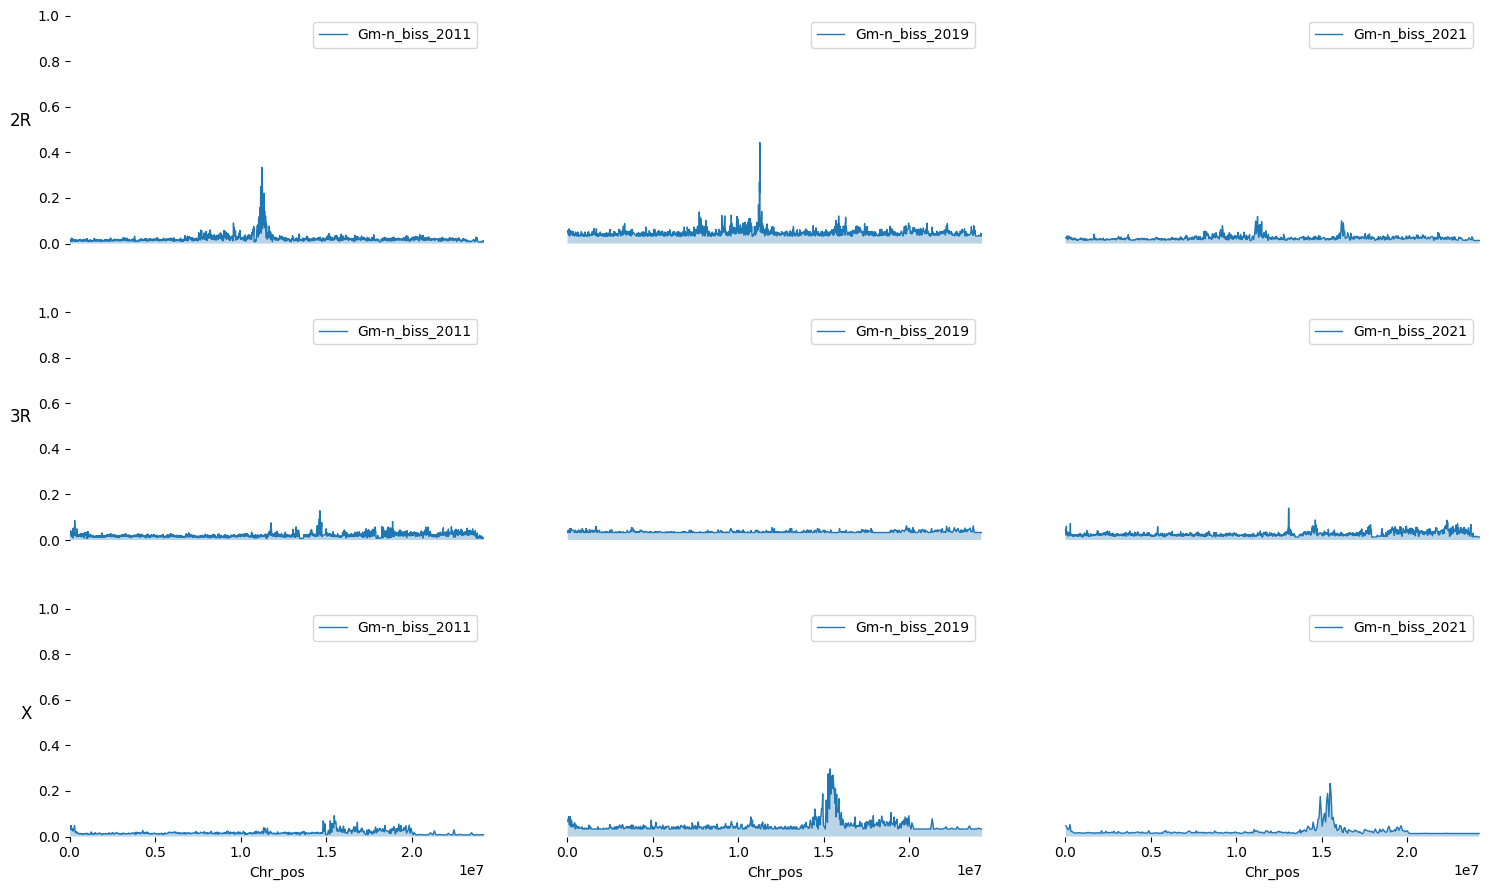

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as lines

# Load your data
"""gambia_data = pd.read_csv('/content/gambiae_h12_GWSS_results.csv')
coluzzii_data = pd.read_csv('/content/coluzziih12_GWSS_results.csv')
bissau_data = pd.read_csv('/content/bissau_h12_GWSS_results.csv')
melas_data = pd.read_csv('/content/melash12_GWSS_results (1).csv')
arabiensis_data = pd.read_csv('/content/arabiensish12_GWSS_results.csv')
final_h12_df = pd.concat([gambia_data, coluzzii_data, bissau_data, melas_data, arabiensis_data])"""
biss_2011 = pd.read_csv('/content/bissau_GM-N_biss_2011_h12_GWSS_results.csv')
biss_2019 = pd.read_csv('/content/bissau_GM-N_biss_2019_h12_GWSS_results.csv')
biss_2021 = pd.read_csv('/content/bissau_GM-N_biss_2021_h12_GWSS_results.csv')
final_h12_df = pd.concat([biss_2011, biss_2019,biss_2021 ])
data = final_h12_df # Replace with your actual data source
data['chrom'] = data['chrom'].astype(str)

# Define cohorts and chromosomes
cohorts = data['Cohort'].unique()
chromosomes = data['chrom'].unique()

# Define helper function for chromosome structure
def plotChromLines(ax, start, end, contig_label):
    """
    Draw chromosome structure on the bottom panel.
    """
    ax.add_line(lines.Line2D([start, end], [4, 6], color='#36454F', linewidth=3))
    ax.add_line(lines.Line2D([start, start + 5_000_000], [4.5, 4], color='#36454F', linewidth=3))
    ax.add_line(lines.Line2D([end, end - 5_000_000], [4.5, 4], color='#36454F', linewidth=3))
    ax.text((start + end) / 2, 6.5, contig_label, fontsize=14, ha='center')

# Set up the figure and subplots
fig, axes = plt.subplots(len(chromosomes), len(cohorts), figsize=(15, len(chromosomes) * 3))

# Gene annotation positions
annotations = {
    '2L': {'2e6': 'Vgsc', '2.85e7': 'COEAE2F\n Aldehyde oxydase\n AGAP006238'},
    '2R': {'2.85e7': 'CYP450', '1.8e7': 'NADPH'},
    '3R': {'2e7': 'Gste2'},
    '3L': {'1.50e7': 'Unknows', '1.98e7': 'AGAP011231'},
    'X': {'1.5e7': 'CPR125\n Cyp9k1'}
}
gambiae_annotations = {
    '2L': {'2e6': 'Vgsc', '2.85e7': 'COEAE2F\n Aldehyde oxydase\n AGAP006238'},
    '2R': {'2.85e7': 'COEAE6O\n CYP450', '6.1e7': 'Unknows'},
    '3R': {'2.85e7': 'GSTEs'},
    '3L': {'1.50e7': 'Unknow'},
    'X': {'1.5e7': 'CPR125\n Cyp9k1'}
}
arabiensis_annotations = {
    '2R': {'2.85e7': 'COEAE6O\n CYP450', '4.08e7': 'SP8905'}
}
coluzzii_annotations = {
    '2L': {'2e6': 'Vgsc', '2.2e7': ' E3 ubiquitin-protein\n\n, fumarylacetoacetase'},
    '2R': {'1.8e7': 'Pex16\n \nAGAP002284', '2.85e7': 'CYP450'},
    '3R': {'2.85e7': 'GSTEs'},
    '3L': {'1.50e7': 'Unknow'},
    'X': {'1.5e7': 'CPR125\n Cyp9k1'}
}
bissau_annotations = {
    '2L': {'2e6': 'Vgsc', '1.1e7': 'Unknow', '2.1e7': 'Unknows','2.59e7': 'Unknows'},
    '2R': {'2.85e7': 'CYP450'},
    '3R': {'2.85e7': 'GSTEs', '3.2e7': 'ORs'},
    '3L': {'1.50e7': 'Unknow'},
    'X': {'1.5e7': 'CPR125\n Cyp9k1'}
}

# Adjust axes to 2D array if needed
if len(chromosomes) > 1:
    axes = axes.reshape(len(chromosomes), len(cohorts))

# Plot for each chromosome
for row_idx, chrom in enumerate(chromosomes):
    chrom_data = data[data['chrom'] == chrom]
    max_bp = chrom_data['Chr_pos'].max()

    for col_idx, cohort in enumerate(cohorts):
        ax = axes[row_idx][col_idx] if len(chromosomes) > 1 else axes[col_idx]
        cohort_data = chrom_data[chrom_data['Cohort'] == cohort]

        # Plot H12 as a line plot
        sns.lineplot(
            x=cohort_data['Chr_pos'],
            y=cohort_data['H12'],
            ax=ax,
            #label=f"{chrom}",  # Add chromosome label for legend
            label = (
              fr"$\it{{An.\ {cohort}\ s.s.}}$"
              if cohort == 'gambiae'
              else (fr"$\it{{An.\ {cohort}}}$" if cohort == 'coluzzii' else f"{cohort.capitalize()}"))
            ,
            linewidth=1
        )
        ax.fill_between(cohort_data['Chr_pos'], cohort_data['H12'], alpha=0.3, label=f"{chrom} (H12)")

        # Configure axes
        ax.set_xlim(0, max_bp)
        ax.set_ylim(0, 1)


        if col_idx == 0:
          #ax.set_ylabel(cohort, rotation=0, ha='right', fontsize=12)
          ax.set_ylabel(chrom, rotation=0, ha='right', fontsize=12)
        else:
          ax.get_yaxis().set_visible(False)
        sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
        if row_idx < len(chromosomes) - 1:
            ax.get_xaxis().set_visible(False)

        # Annotate key loci and plot points
        # Manual annotations
        if cohort == 'gambiae':
          for pos, label in gambiae_annotations[chrom].items():
            if chrom != '3L':
              ax.text(float(pos) , 0.6, label, fontsize=10, ha='center', color='brown')
              ax.scatter([float(pos)], [0.5], color='brown', s=10, zorder=3)
        if cohort == 'coluzzii':
          for pos, label in coluzzii_annotations[chrom].items():
            if chrom != '3L' and chrom !='3R':
              if coluzzii_annotations[chrom][pos] == 'CYP450':
                ax.text(float(pos) , 0.5, label, fontsize=10, ha='center', color='brown')
                ax.scatter([float(pos)], [0.4], color='brown', s=10, zorder=3)
              else:
                ax.text(float(pos) , 0.6, label, fontsize=10, ha='center', color='brown')
                ax.scatter([float(pos)], [0.5], color='brown', s=10, zorder=3)

        if cohort == 'bissau':
          for pos, label in bissau_annotations[chrom].items():
            if chrom != '3L' and chrom != '2L':
              if bissau_annotations[chrom][pos] == 'ORs':
                  ax.text(float(pos) , 0.5, label, fontsize=10, ha='center', color='brown')
                  ax.scatter([float(pos)], [0.4], color='brown', s=10, zorder=3)
              else:
                  ax.text(float(pos) , 0.6, label, fontsize=10, ha='center', color='brown')
                  ax.scatter([float(pos)], [0.5], color='brown', s=10, zorder=3)
        if cohort == 'arabiensis':
          if chrom not in ['2L', '3R', '3L', 'X']:
            for pos, label in arabiensis_annotations[chrom].items():
              if arabiensis_annotations[chrom][pos] == 'SP8905':
                ax.text(float(pos) , 0.5, label, fontsize=10, ha='center', color='brown')
                ax.scatter([float(pos)], [0.4], color='brown', s=10, zorder=3)
              else:
                ax.text(float(pos) , 0.6, label, fontsize=10, ha='center', color='brown')
                ax.scatter([float(pos)], [0.5], color='brown', s=10, zorder=3)



# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Save the combined plot
plt.savefig(f'h12_plot.png', dpi=300)
plt.savefig(f'h12_plot.pdf', dpi=300)
plt.show()


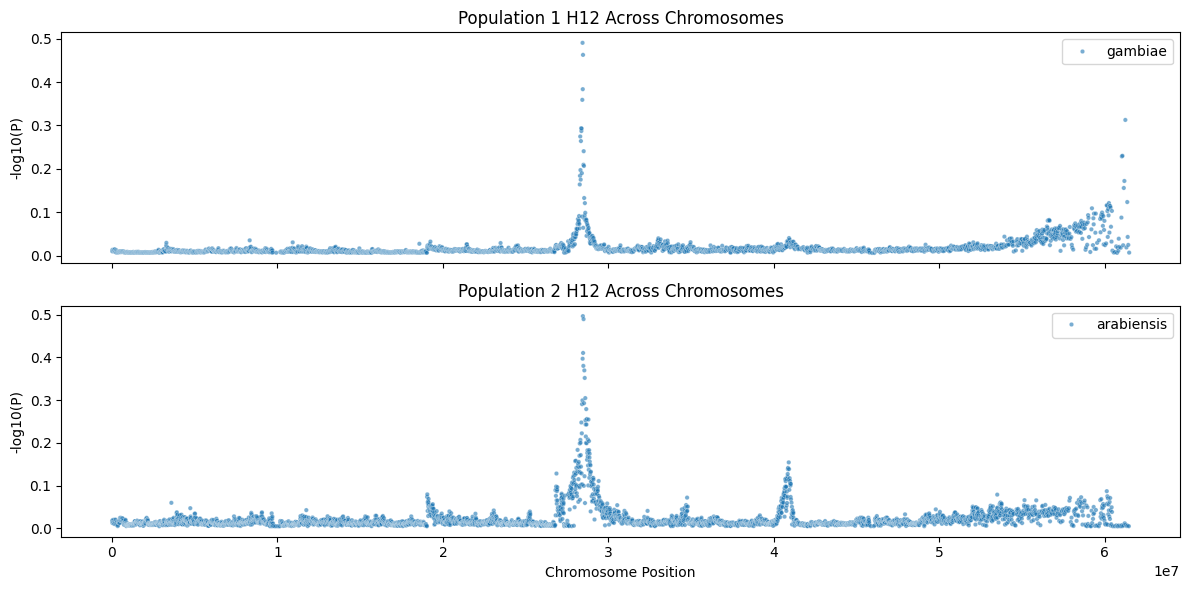

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_h12_two_pops(data1, data2, figsize=(12, 6), title=None, xlab="Chromosome Position",
                      ylab="-log10(P)", legend_loc="best", fig_name=None):
    """
    Plot H12 values for two populations in a Manhattan-style plot.

    Parameters:
    data1 (pd.DataFrame): Data for the first population with 'Chr_pos' and 'H12' columns.
    data2 (pd.DataFrame): Data for the second population with 'Chr_pos' and 'H12' columns.
    figsize (tuple): Size of the figure.
    title (str): Title of the plot.
    xlab (str): Label for x-axis.
    ylab (str): Label for y-axis.
    legend_loc (str): Location of the legend.
    fig_name (str): Name of the file to save the figure.
    """

    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    # Top plot (first population)
    sns.scatterplot(x='Chr_pos', y='H12', hue='Cohort', data=data1, ax=axs[0], s=10, alpha=0.6)
    axs[0].set_title(f"Population 1 {title}" if title else "Population 1")
    axs[0].set_ylabel(ylab)
    axs[0].legend(loc=legend_loc)

    # Bottom plot (second population)
    sns.scatterplot(x='Chr_pos', y='H12', hue='Cohort', data=data2, ax=axs[1], s=10, alpha=0.6)
    axs[1].set_title(f"Population 2 {title}" if title else "Population 2")
    axs[1].set_xlabel(xlab)
    axs[1].set_ylabel(ylab)
    axs[1].legend(loc=legend_loc)
    #axs[1].set_ylim(axs[0].get_ylim())  # Set y-axis limits to match top plot

    # Adjust layout
    plt.tight_layout()

    # Save figure if filename is provided
    if fig_name:
        plt.savefig(f"{fig_name}.png", dpi=300, bbox_inches='tight')

    plt.show()

# Example usage with two datasets (replace df1 and df2 with your data)
df1 = pd.read_csv('/content/gambiae_h12_GWSS_results.csv')
df2 = pd.read_csv('/content/arabiensish12_GWSS_results.csv')

"""GM_L_h12_df = pd.read_csv('/content/coluzzii_GM-L_h12_GWSS_results.csv')
GM_M_h12_df = pd.read_csv('/content/coluzzii_GM-M_h12_GWSS_results.csv')
GM_N_H12_df = pd.read_csv('/content/coluzzii_GM-N_h12_GWSS_results.csv')
GM_U_h12_df = pd.read_csv('/content/coluzzii_GM-U_h12_GWSS_results.csv')
GM_W_h12_df = pd.read_csv('/content/coluzzii_GM-W_h12_GWSS_results.csv')"""
chr="2R"
plot_h12_two_pops(data1=df1.query(f"chrom=='{chr}'"), data2=df2.query(f"chrom=='{chr}'"), title="H12 Across Chromosomes")


In [ ]:
#list of gene for region under selection in 2L chromosome in gambiae taxon
genes_list = (
    ag3.genome_features(region=["2R", "2L","3R", "3L", "X"]).query("type!='chromosome'")
    [["contig", "ID", "start", "end", "Name", "description","type"]]
    .set_index("ID")
)

# Add
genes_list
genes_list.reset_index(inplace=True)
genes_list.to_csv('genes_list.csv', index=False)
#Save in rda format
"""# get dict of ID and Name
gene_dict = genes_list.set_index('ID')['Name'].to_dict()
gene_dict
gene_dict = genes_list['Name'].to_dict()
gene_dict
# remove na value
gene_dict = {k: v for k, v in gene_dict.items() if not pd.isna(v)}
gene_dict"""

,ID,contig,start,end,Name,description,type
0,AGAP004677,2L,157348,186936,NaN,methylenetetrahydrofolate dehydrogenase(NAD ) ...,gene
1,AGAP004677-RA,2L,157348,181305,NaN,NaN,mRNA
2,NaN,2L,157348,157495,NaN,NaN,three_prime_UTR
3,NaN,2L,157348,157623,AGAP004677-RB-E4,NaN,exon
4,AGAP004677-RB,2L,157348,186936,NaN,NaN,mRNA
...,...,...,...,...,...,...,...
191386,AGAP028967-RA,X,24359754,24359921,NaN,NaN,rRNA
191387,NaN,X,24359754,24359921,AGAP028967-RA-E1,NaN,exon
191388,AGAP028974,X,24390339,24391011,LSU_rRNA_eukarya,Eukaryotic large subunit ribosomal RNA [Source...,ncRNA_gene
191389,AGAP028974-RA,X,24390339,24391011,NaN,NaN,rRNA


In [ ]:
import pandas as pd

h12_data = pd.read_csv('/content/arabiensish12_GWSS_results.csv')
#h12_data = h12_data.query('chrom=="2R"')
h12_data = h12_data.rename(columns={
    "chrom": "contig",
    "Chr_pos": "position",
    "H12": "H12"
})
h12_data
genes_list.query("Name=='COEAE2F'")
#gene_list = pd.read_csv('/content/genes_list.csv')

# Step 1: Merge H12 data with gene_list based on position match
def assign_gene_info(h12_df, gene_df):
    """
    For each H12 position, assign the gene ID and Name if it falls between start and end.
    """
    result = []
    for _, h12_row in h12_df.iterrows():
        chrom, pos = h12_row["contig"], h12_row["position"]

        # Find matching gene
        matching_genes = gene_df[
            (gene_df["contig"] == chrom) & (gene_df["start"] <= pos) & (gene_df["end"] >= pos)
        ]

        if not matching_genes.empty:
            for _, gene_row in matching_genes.iterrows():
                result.append({
                    "contig": chrom,
                    "position": pos,
                    "H12": h12_row["H12"],
                    "gene_id": gene_row["ID"],
                    "gene_name": gene_row["Name"],
                    "gene_description": gene_row["description"],
                    "type": gene_row["type"]
                })
        else:
            # No matching gene found
            result.append({
                "contig": chrom,
                "position": pos,
                "H12": h12_row["H12"],
                "gene_id": "No Gene",
                "gene_name": "No Gene",
                "gene_description": "No Gene"
            })

    return pd.DataFrame(result)

# Step 2: Run the function
h12_with_genes = assign_gene_info(h12_data, genes_list)
# Replace NaN in gene_name by gene_id
h12_with_genes['gene_name'].fillna(h12_with_genes['gene_id'], inplace=True)
# Display the result
h12_with_genes.query("contig=='2L'")

# save
h12_with_genes.to_csv('arabiensis_h12_with_genes.csv', index=False)
h12_with_genes

,contig,position,H12,gene_id,gene_name,gene_description,type
0,2L,7.127474e+04,0.00540,No Gene,No Gene,No Gene,NaN
1,2L,1.650170e+05,0.00565,AGAP004677,AGAP004677,methylenetetrahydrofolate dehydrogenase(NAD ) ...,gene
2,2L,1.650170e+05,0.00565,AGAP004677-RA,AGAP004677-RA,NaN,mRNA
3,2L,1.650170e+05,0.00565,AGAP004677-RB,AGAP004677-RB,NaN,mRNA
4,2L,2.258059e+05,0.00575,No Gene,No Gene,No Gene,NaN
...,...,...,...,...,...,...,...
45982,X,2.424633e+07,0.03485,AGAP001094,run,runt [Source:VB Community Annotation],gene
45983,X,2.424633e+07,0.03485,AGAP001094-RA,AGAP001094-RA,NaN,mRNA
45984,X,2.428542e+07,0.00515,No Gene,No Gene,No Gene,NaN
45985,X,2.433253e+07,0.00515,No Gene,No Gene,No Gene,NaN


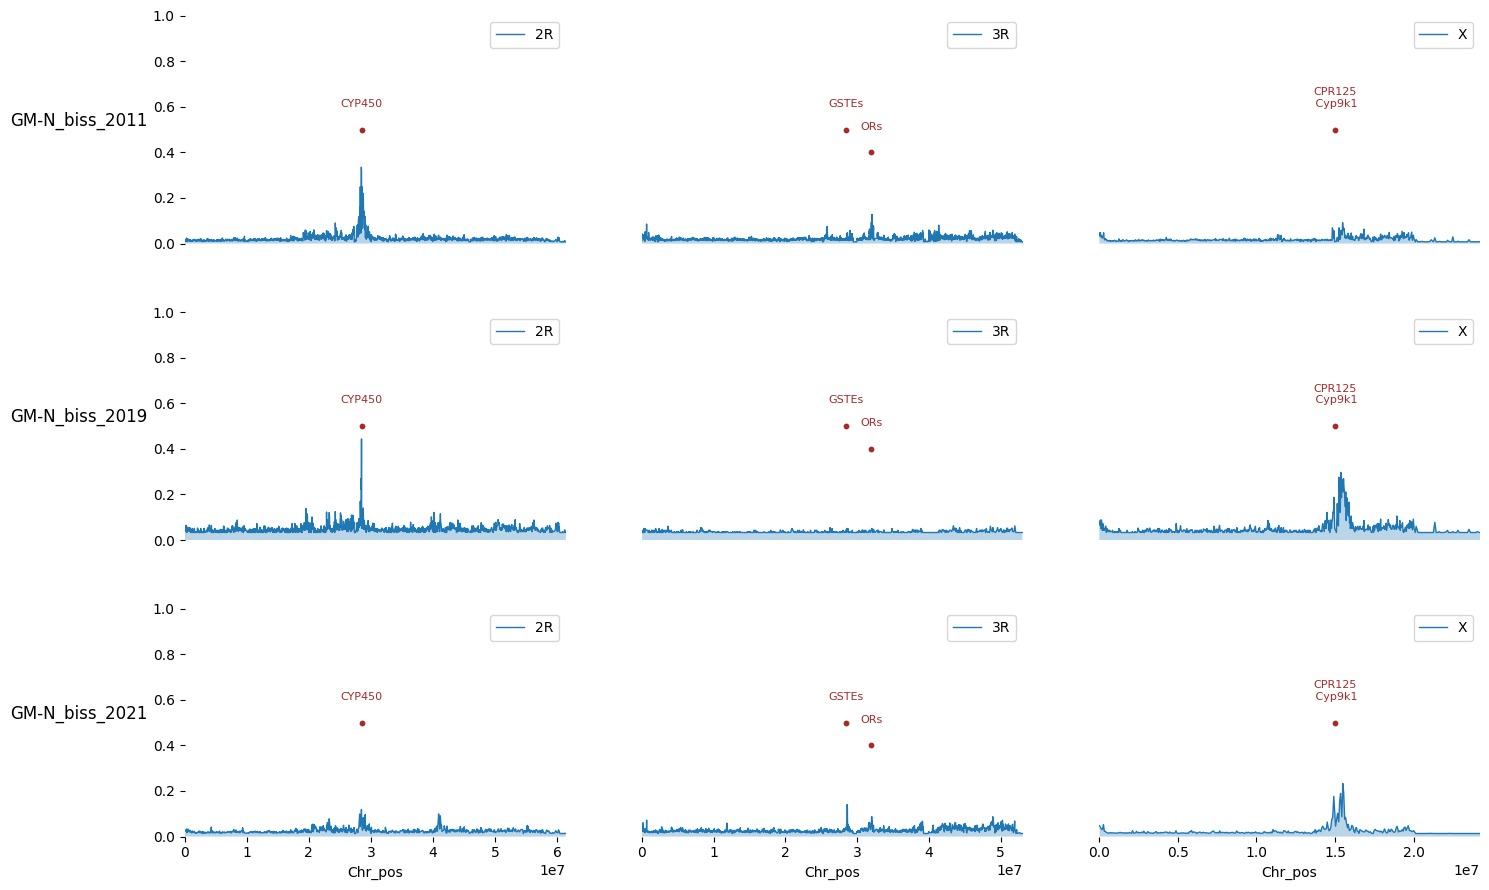

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as lines

# Load your data
"""cohort_A = pd.read_csv('/content/bissau_GM-M_h12_GWSS_results.csv')
cohort_B = pd.read_csv('/content/bissau_GM-N_h12_GWSS_results.csv')
cohort_C = pd.read_csv('/content/bissau_GM-W_h12_GWSS_results.csv')
cohort1 = pd.read_csv('/content/bissau_GM-M_biss_2019_h12_GWSS_results.csv')
cohort2 = pd.read_csv('/content/bissau_GM-N_biss_2011_h12_GWSS_results.csv')
cohort3 = pd.read_csv('/content/bissau_GM-N_biss_2019_h12_GWSS_results.csv')
cohort4 = pd.read_csv('/content/bissau_GM-N_biss_2021_h12_GWSS_results.csv')
cohort5 = pd.read_csv('/content/bissau_GM-W_biss_2019_h12_GWSS_results.csv')
h12_region = pd.concat([cohort_A, cohort_B, cohort_C])
h12_year_df = pd.concat([cohort1, cohort2, cohort3, cohort4, cohort5])
h12_year_df = sorted_H12_data(h12_year_df)
final_h12_df = pd.concat([h12_region, h12_year_df])

gambia_data = pd.read_csv('/content/gambiae_h12_GWSS_results.csv')
coluzzii_data = pd.read_csv('/content/coluzzii_h12_GWSS_results.csv')
bissau_data = pd.read_csv('/content/bissau_h12_GWSS_results.csv')
melas_data = pd.read_csv('/content/melash12_GWSS_results (1).csv')
arabiensis_data = pd.read_csv('/content/arabiensish12_GWSS_results.csv')
final_h12_df = pd.concat([gambia_data, coluzzii_data, bissau_data, melas_data, arabiensis_data])"""
biss_2011 = pd.read_csv('/content/bissau_GM-N_biss_2011_h12_GWSS_results.csv')
biss_2019 = pd.read_csv('/content/bissau_GM-N_biss_2019_h12_GWSS_results.csv')
biss_2021 = pd.read_csv('/content/bissau_GM-N_biss_2021_h12_GWSS_results.csv')
final_h12_df = pd.concat([biss_2011, biss_2019,biss_2021 ])
data = final_h12_df  # Replace with your actual DataFrame
data['chrom'] = data['chrom'].astype(str)
# Define cohorts and chromosomes
cohorts = data['Cohort'].unique()
chromosomes = data['chrom'].unique()
# Gene annotation positions

gambiae_annotations = {
    '2L': {'2e6': 'Vgsc', '2.85e7': 'COEAE2F\n Aldehyde oxydase\n AGAP006238'},
    '2R': {'2.85e7': 'COEAE6O\n CYP450', '6.1e7': 'Unknows'},
    '3R': {'2.85e7': 'GSTEs'},
    '3L': {'1.50e7': 'Unknow'},
    'X': {'1.5e7': 'CPR125\n Cyp9k1'}
}
coluzzii_annotations = {
    '2L': {'2e6': 'Vgsc', '2.2e7': ' E3 ubiquitin-protein\n\n, fumarylacetoacetase'},
    '2R': {'1.8e7': 'Pex16\n \nAGAP002284', '2.85e7': 'CYP450'},
    '3R': {'2.85e7': 'GSTEs'},
    '3L': {'1.50e7': 'Unknow'},
    'X': {'1.5e7': 'CPR125\n Cyp9k1'}
}
bissau_annotations = {
    '2L': {'2e6': 'Vgsc', '1.1e7': 'Unknow', '2.1e7': 'Unknows','2.59e7': 'Unknows'},
    '2R': {'2.85e7': 'CYP450'},
    '3R': {'2.85e7': 'GSTEs', '3.2e7': 'ORs'},
    '3L': {'1.50e7': 'Unknow'},
    'X': {'1.5e7': 'CPR125\n Cyp9k1'}
}

# Define helper function to draw chromosome lines
def plotChromLines(ax, start, end, contig_label):
    """
    Draw chromosome structure on the bottom panel.
    """
    ax.add_line(lines.Line2D([start, end], [4, 6], color='#36454F', linewidth=3))
    ax.add_line(lines.Line2D([start, start + 5_000_000], [4.5, 4], color='#36454F', linewidth=3))
    ax.add_line(lines.Line2D([end, end - 5_000_000], [4.5, 4], color='#36454F', linewidth=3))
    ax.text((start + end) / 2, 6.5, contig_label, fontsize=14, ha='center')

# Set up the figure and subplots
fig, axes = plt.subplots(len(cohorts), len(chromosomes), figsize=(15, len(cohorts) * 3), sharex='col', sharey='row')

# Plot for each cohort (row) and chromosome (column)
for row_idx, cohort in enumerate(cohorts):
    cohort_data = data[data['Cohort'] == cohort]
    for col_idx, chrom in enumerate(chromosomes):
        chrom_data = cohort_data[cohort_data['chrom'] == chrom]
        max_bp = chrom_data['Chr_pos'].max()

        # Select the appropriate subplot
        ax = axes[row_idx, col_idx] if len(cohorts) > 1 else axes[col_idx]

        # Plot H12 as a line plot
        sns.lineplot(
            x=chrom_data['Chr_pos'],
            y=chrom_data['H12'],
            ax=ax,
            label=f"{chrom}",  # Add chromosome label for legend
            linewidth=1
        )
        ax.fill_between(chrom_data['Chr_pos'], chrom_data['H12'], alpha=0.3, label=f"{chrom} (H12)")

        # Configure axes
        ax.set_xlim(0, max_bp if pd.notna(max_bp) else 1)
        ax.set_ylim(0, 1)
        if col_idx == 0:
            #reformated_cohort = fr"$\it{{An.\ {cohort}\ s.s.}}$" if cohort == 'gambiae' else (fr"$\it{{An.\ {cohort}}}$" if cohort == 'coluzzii' else f"{cohort.capitalize()}")
            ax.set_ylabel(cohort, rotation=0, ha='right', fontsize=12)
        else:
            ax.get_yaxis().set_visible(False)

        sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
        if row_idx < len(cohorts) - 1:
            ax.get_xaxis().set_visible(False)

        # Add a legend for each chromosome
        """if row_idx == 0:
            ax.set_title(chrom, fontsize=14)"""
                # Annotate key loci and plot points
        # Manual annotations
        if cohort == 'gambiae':
          for pos, label in gambiae_annotations[chrom].items():
            if chrom != '3L':
              ax.text(float(pos) , 0.6, label, fontsize=8, ha='center', color='brown')
              ax.scatter([float(pos)], [0.5], color='brown', s=10, zorder=3)
        if cohort == 'coluzzii':
          for pos, label in coluzzii_annotations[chrom].items():
            if chrom != '3L' and chrom !='3R':
              if coluzzii_annotations[chrom][pos] == 'CYP450':
                ax.text(float(pos) , 0.5, label, fontsize=8, ha='center', color='brown')
                ax.scatter([float(pos)], [0.4], color='brown', s=10, zorder=3)
              else:
                ax.text(float(pos) , 0.6, label, fontsize=8, ha='center', color='brown')
                ax.scatter([float(pos)], [0.5], color='brown', s=10, zorder=3)

        #if cohort == 'bissau':
        else:
          for pos, label in bissau_annotations[chrom].items():
            if chrom != '3L' and chrom != '2L':
              if bissau_annotations[chrom][pos] == 'ORs':
                  ax.text(float(pos) , 0.5, label, fontsize=8, ha='center', color='brown')
                  ax.scatter([float(pos)], [0.4], color='brown', s=10, zorder=3)
              else:
                  ax.text(float(pos) , 0.6, label, fontsize=8, ha='center', color='brown')
                  ax.scatter([float(pos)], [0.5], color='brown', s=10, zorder=3)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.2)
#plt.subplots_adjust(left=0.1, bottom=0.5)  # Adjust values as needed
# Save the combined plot
plt.savefig('h12_by_cohort_and_chromosome.pdf', dpi=300)
plt.savefig('h12_by_cohort_and_chromosome.png', dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_H12(data, annotations=None, figsize=(15, 8), ax=None, title=None, xlab=None,
             ylab=None, legend_loc=(1, 1.25), fig_name=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, offset=5)

    # Assign x-axis positions based on chromosome lengths
    cumulative_position = 0
    chr_positions = []
    chr_boundaries = []
    chr_offsets = {}

    for chrom in data['chrom'].unique():  # No sorting applied
        chr_data = data[data['chrom'] == chrom].copy()
        chr_min = chr_data['Chr_pos'].min()
        chr_max = chr_data['Chr_pos'].max()
        chr_length = chr_max - chr_min

        # Adjust chromosome positions
        chr_data['Chromosomes'] = chr_data['Chr_pos'] - chr_min + cumulative_position
        data.loc[data['chrom'] == chrom, 'Chromosomes'] = chr_data['Chromosomes']

        # Save midpoint for chromosome label
        mid_pos = cumulative_position + chr_length / 2
        chr_positions.append((chrom, mid_pos))

        # Save chromosome boundary
        chr_boundaries.append(cumulative_position)

        # Store chromosome start position
        chr_offsets[chrom] = cumulative_position

        # Update cumulative position
        cumulative_position += chr_length + 1  # Add buffer space

    # Define colors for the cohorts
    taxon_color = {
        'An. coluzzii': 'orange',
        'An. gambiae s.s': 'blue',
        'Bissau': 'purple',
        'An. melas': 'green',
        'An. arabiensis': 'red'
    }

    # Plot H12 values
    sns.lineplot(x='Chromosomes', y='H12', hue='Cohort', palette=taxon_color, data=data, ax=ax, linewidth=0.5)

    # Add vertical lines to separate chromosomes
    for boundary in chr_boundaries:
        ax.axvline(x=boundary, color='gray', linestyle='dashed', alpha=0.40)

    # Set x-ticks to chromosome midpoints
    ax.set_xticks([pos for _, pos in chr_positions])
    ax.set_xticklabels([chrom for chrom, _ in chr_positions], rotation=45, ha="right")

    # Set axis titles with spacing
    if title:
        ax.set_title(title, pad=30, fontsize=14, fontweight='bold')  # Moves title higher
    if xlab:
        ax.set_xlabel(xlab, fontsize=14, fontweight='bold')
    if ylab:
        ax.set_ylabel(ylab, fontsize=12)

    # Add annotations
    if annotations:
        for label, chrom, pos, text_x, text_y, y_text_offset in annotations:
            if chrom in chr_offsets:
                genome_pos = pos - data[data['chrom'] == chrom]['Chr_pos'].min() + chr_offsets[chrom]
                text_x_adj = text_x - data[data['chrom'] == chrom]['Chr_pos'].min() + chr_offsets[chrom]

                ax.annotate(label,
                            xy=(genome_pos, text_y),
                            xytext=(text_x_adj, text_y + y_text_offset),
                            color='darkred',
                            fontsize=14,
                            arrowprops=dict(arrowstyle="->", color='slategrey'))

    # Set legend outside the plot area
    legend = ax.legend(loc='upper right', bbox_to_anchor=legend_loc, frameon=False, fontsize=18, title_fontsize=19)
    for text in legend.get_texts():
        if text.get_text() in ['An. coluzzii', 'An. gambiae s.s', 'An. melas', 'An. arabiensis']:  # Apply italic only to these
          text.set_fontstyle('italic')
        text.set_fontweight('bold')

    # Set y-axis limits
    ax.set_ylim(-1, 1)

    # Save figure
    if fig_name:

        fig.savefig(f"{fig_name}_high.png", dpi=600, bbox_inches='tight')

        # Vector formats that scale perfectly
        fig.savefig(f"{fig_name}.pdf", bbox_inches='tight', format='pdf')
        fig.savefig(f"{fig_name}.svg", bbox_inches='tight', format='svg')

        # Standard PNG
        fig.savefig(f"{fig_name}.png", dpi=300, bbox_inches='tight')

    return ax


<Axes: xlabel='Chromosomes', ylabel='H12'>

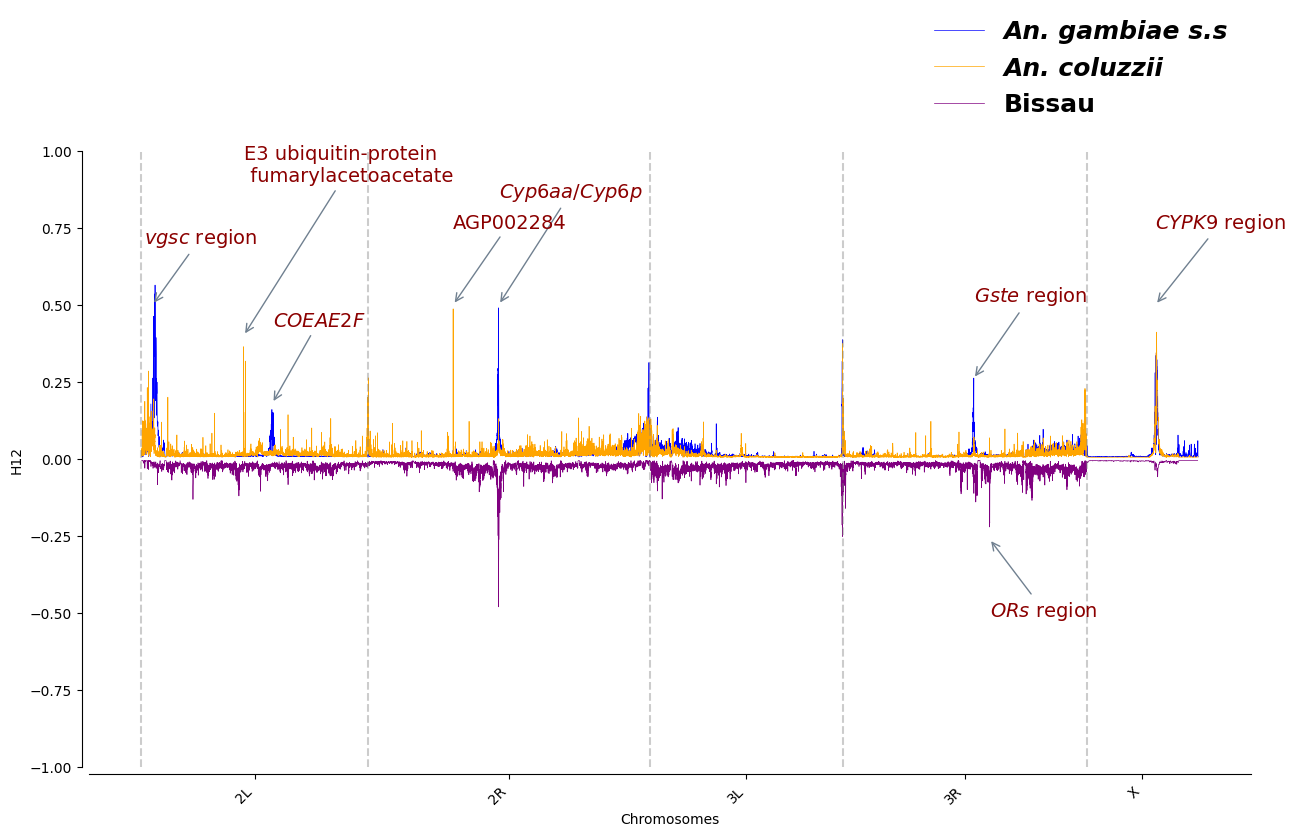

In [ ]:
#Annotations
annotations = [
    ('$vgsc$ region', '2L', 2431617, 600000, 0.5, 0.2),
    ('$Gste$ region', '3R', 28500000, 28600000, 0.26, 0.25),
    ('$Cyp6aa/Cyp6p$', '2R', 28500000, 28600000, 0.5, 0.35),
    ('$ORs$ region', '3R', 32000000, 32080000, -0.26, -0.25),
    ('$CYPK9$ region', 'X', 15000000, 15010000, 0.5, 0.25),
    ('$COEAE2F$', '2L', 28500000, 28600000, 0.18, 0.25),
    ('E3 ubiquitin-protein\n fumarylacetoacetate ','2L', 22281000,22283000, 0.40, 0.5),
    ('AGP002284', '2R', 18570000, 18600000, 0.5, 0.25)
]

# Load data
gambia_data = pd.read_csv('/content/gambiae_h12_GWSS_results.csv')
coluzzii_data = pd.read_csv('/content/coluzzii_h12_GWSS_results.csv')
bissau_data = pd.read_csv('/content/bissau_h12_GWSS_results.csv')
bissau_data['H12'] = bissau_data['H12'] * (-1)

# Combine data
final_h12_df = pd.concat([gambia_data, coluzzii_data, bissau_data])
final_h12_df['Cohort'] = final_h12_df['Cohort'].replace({
    'coluzzii': 'An. coluzzii',
    'bissau': 'Bissau',
    'gambiae': 'An. gambiae s.s'
})

# Plot
plot_H12(data=final_h12_df, annotations=annotations, fig_name="GWSS_results")


<Axes: xlabel='Chromosomes', ylabel='H12'>

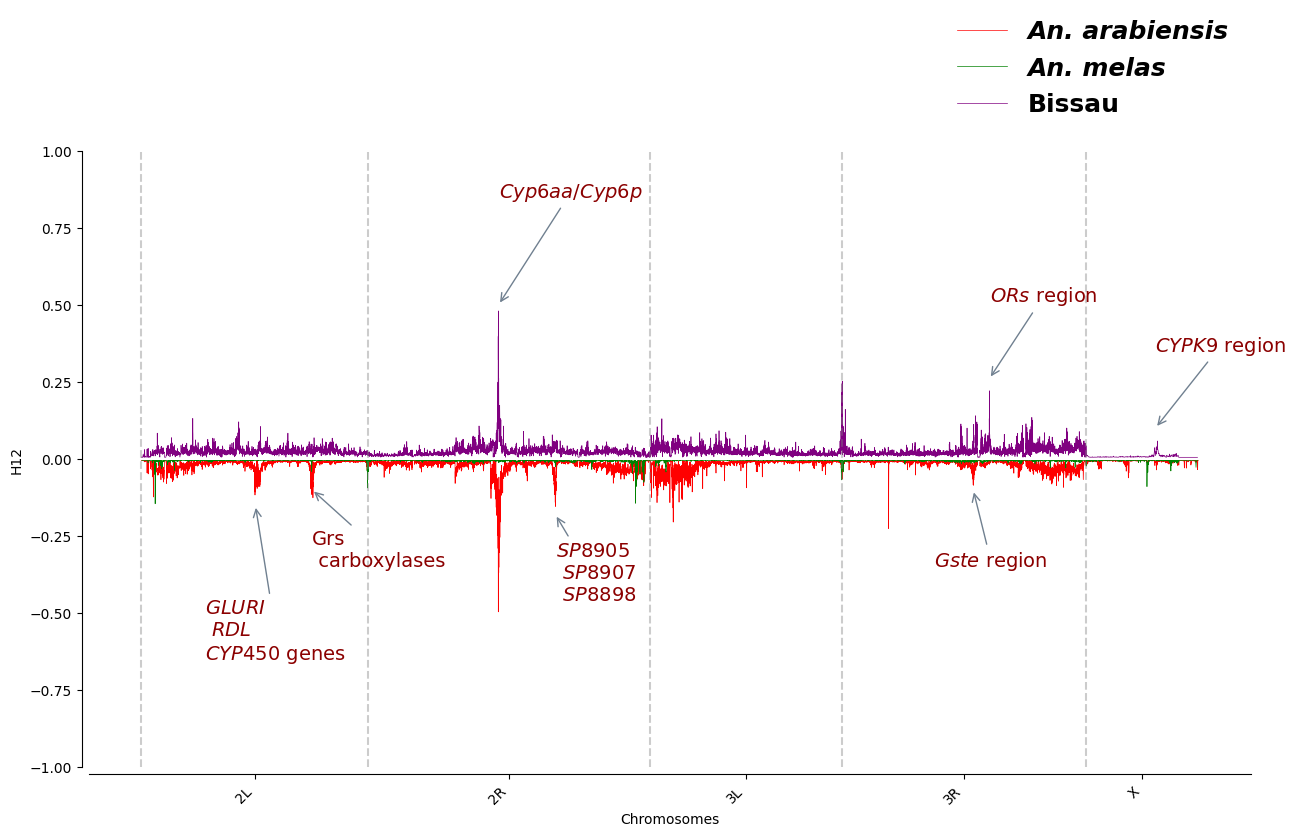

In [ ]:
arabiensis = pd.read_csv('/content/arabiensish12_GWSS_results.csv')
melas = pd.read_csv('/content/melash12_GWSS_results (1).csv')
gambiae = pd.read_csv('/content/gambiae_h12_GWSS_results.csv')
#coluzzii = pd.read_csv('/content/coluzzii_h12_GWSS_results.csv')
bissau_data = pd.read_csv('/content/bissau_h12_GWSS_results.csv')
melas['H12'] = melas['H12'] * (-1)
arabiensis['H12'] = arabiensis['H12'] * (-1)
#gambiae['H12'] = gambiae['H12'] * (-1)


final_h12_df = pd.concat([arabiensis,melas, bissau_data])
final_h12_df['Cohort'] = final_h12_df['Cohort'].replace({
    'arabiensis': 'An. arabiensis',
    'melas': 'An. melas',
    'gambiae': 'An. gambiae',
    'bissau': 'Bissau',
    'coluzzii': 'An. coluzzii'
})

annotations = [
    #('$vgsc$ region', '2L', 2431617, 600000, 0.5, 0.2),
    ('$Gste$ region', '3R', 28500000, 20000000, -0.10, -0.25),
    ('$Cyp6aa/Cyp6p$', '2R', 28500000, 28600000, 0.5, 0.35),
    ('$SP8905$ \n $SP8907$ \n $SP8898$ \n', '2R', 40850000, 40930000, -0.18, -0.35),
    ('$ORs$ region', '3R', 32000000, 32080000, 0.26, 0.25),
    ('$CYPK9$ region', 'X', 15050000, 15010000, 0.10, 0.25),
    #('$COEAE2F$', '2L', 28500000, 28600000, 0.18, 0.25),
    ('$GLURI$ \n $RDL$ \n$CYP450$ genes', '2L', 24882820, 14000000, -0.15,-0.5), #2L:25882820-24785920
    ('Grs\n carboxylases', '2L', 37200000,37300000, -0.10, -0.25)
    #('E3 ubiquitin-protein\n fumarylacetoacetate ','2L', 22281000,22283000, 0.40, 0.5),
    #('AGP002284 ', '2R', 18570000, 18600000, 0.5, 0.25)
]


plot_H12(data=final_h12_df, annotations=annotations,fig_name="GWSS_results_2")

<Axes: xlabel='Chromosomes', ylabel='H12'>

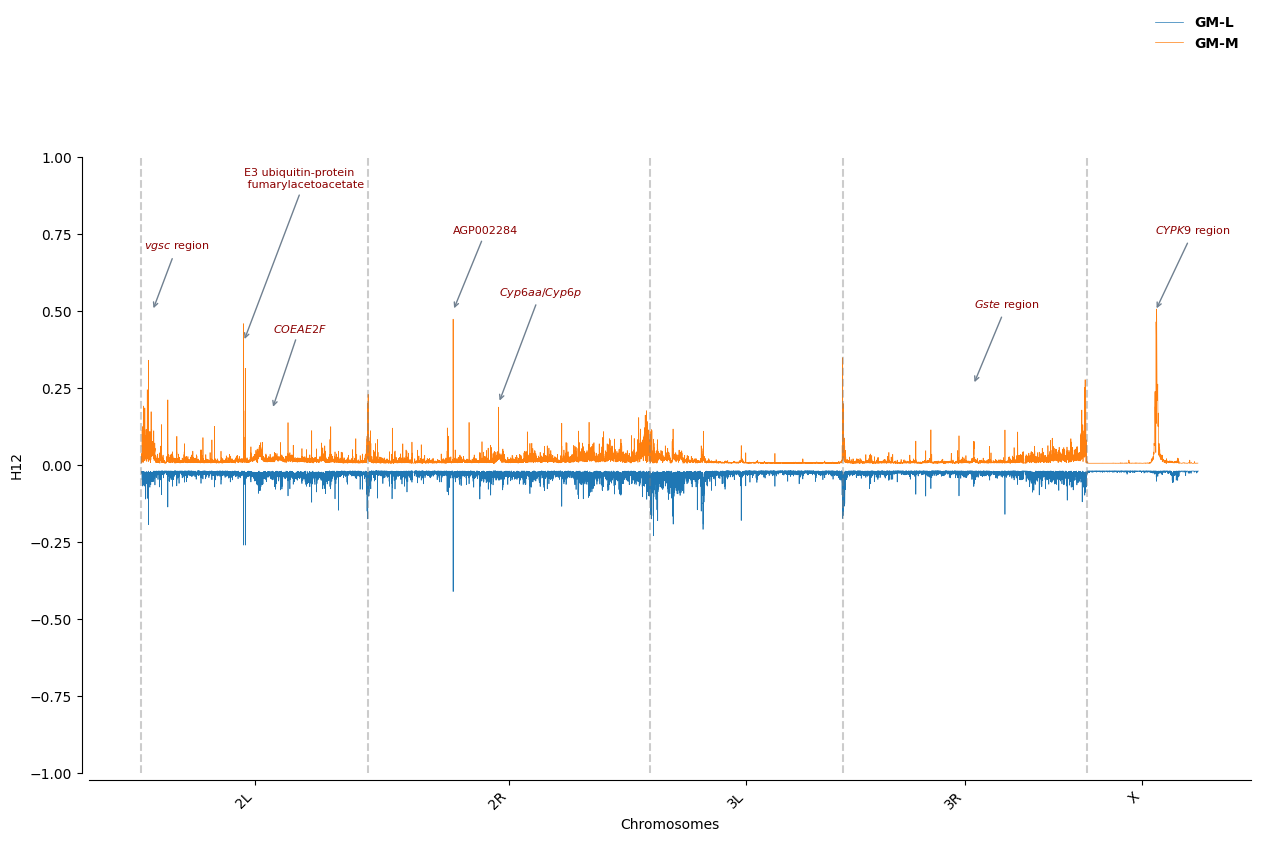

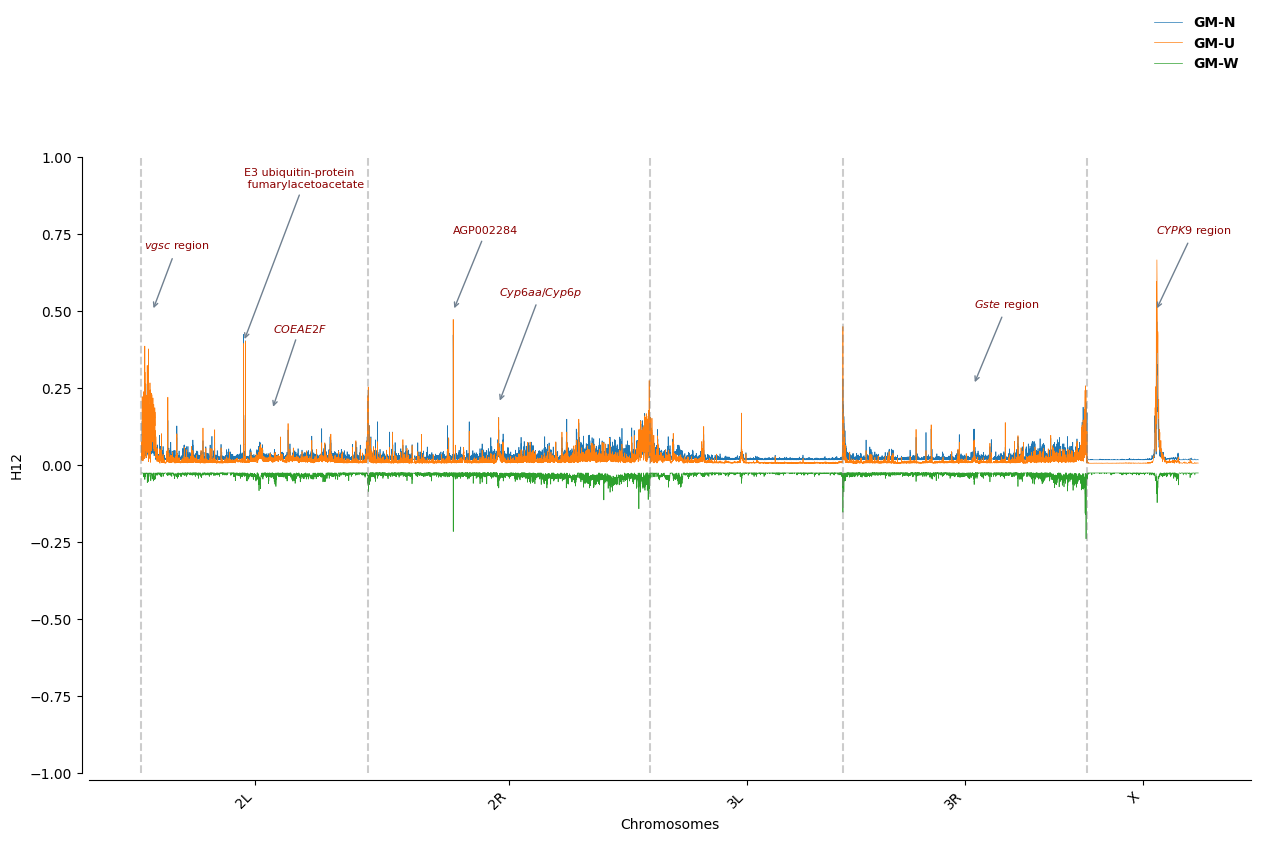

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_H12(data, annotations=None, figsize=(15, 8), ax=None, title=None, xlab=None,
             ylab=None, legend_loc=(1, 1.25), fig_name=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, offset=5)

    # Assign x-axis positions based on chromosome lengths
    cumulative_position = 0
    chr_positions = []
    chr_boundaries = []
    chr_offsets = {}

    for chrom in data['chrom'].unique():  # No sorting applied
        chr_data = data[data['chrom'] == chrom].copy()
        chr_min = chr_data['Chr_pos'].min()
        chr_max = chr_data['Chr_pos'].max()
        chr_length = chr_max - chr_min

        # Adjust chromosome positions
        chr_data['Chromosomes'] = chr_data['Chr_pos'] - chr_min + cumulative_position
        data.loc[data['chrom'] == chrom, 'Chromosomes'] = chr_data['Chromosomes']

        # Save midpoint for chromosome label
        mid_pos = cumulative_position + chr_length / 2
        chr_positions.append((chrom, mid_pos))

        # Save chromosome boundary
        chr_boundaries.append(cumulative_position)

        # Store chromosome start position
        chr_offsets[chrom] = cumulative_position

        # Update cumulative position
        cumulative_position += chr_length + 1  # Add buffer space

    # Plot H12 values
    sns.lineplot(x='Chromosomes', y='H12', hue='Cohort', data=data, ax=ax, linewidth=0.5)

    # Add vertical lines to separate chromosomes
    for boundary in chr_boundaries:
        ax.axvline(x=boundary, color='gray', linestyle='dashed', alpha=0.40)

    # Set x-ticks to chromosome midpoints
    ax.set_xticks([pos for _, pos in chr_positions])
    ax.set_xticklabels([chrom for chrom, _ in chr_positions], rotation=45, ha="right")

    # Set axis titles with spacing
    if title:
        ax.set_title(title, pad=30, fontsize=14, fontweight='bold')  # Moves title higher
    if xlab:
        ax.set_xlabel(xlab, fontsize=12)
    if ylab:
        ax.set_ylabel(ylab, fontsize=12)

    # Add annotations
    if annotations:
        for label, chrom, pos, text_x, text_y, y_text_offset in annotations:
            if chrom in chr_offsets:
                genome_pos = pos - data[data['chrom'] == chrom]['Chr_pos'].min() + chr_offsets[chrom]
                text_x_adj = text_x - data[data['chrom'] == chrom]['Chr_pos'].min() + chr_offsets[chrom]

                ax.annotate(label,
                            xy=(genome_pos, text_y),
                            xytext=(text_x_adj, text_y + y_text_offset),
                            color='darkred',
                            fontsize=8,
                            arrowprops=dict(arrowstyle="->", color='slategrey'))

    # Set legend outside the plot area
    legend = ax.legend(loc='upper right', bbox_to_anchor=legend_loc, frameon=False)
    for text in legend.get_texts():
        if text.get_text() in ['An. coluzzii', 'An. gambiae', 'An. melas', 'An. arabiensis']:  # Apply italic only to these
          text.set_fontstyle('italic')
        text.set_fontweight('bold')

    # Set y-axis limits
    ax.set_ylim(-1, 1)

    # Save figure
    if fig_name:
        fig.savefig(f"{fig_name}.png", dpi=300, bbox_inches='tight')

    return ax

GM_L_h12_df = pd.read_csv('/content/coluzzii_GM-L_h12_GWSS_results.csv')
GM_M_h12_df = pd.read_csv('/content/coluzzii_GM-M_h12_GWSS_results.csv')
GM_N_H12_df = pd.read_csv('/content/coluzzii_GM-N_h12_GWSS_results.csv')
GM_U_h12_df = pd.read_csv('/content/coluzzii_GM-U_h12_GWSS_results.csv')
GM_W_h12_df = pd.read_csv('/content/coluzzii_GM-W_h12_GWSS_results.csv')

GM_L_h12_df['H12'] = GM_L_h12_df['H12'] * (-1)
GM_W_h12_df['H12'] = GM_W_h12_df['H12'] * (-1)
#GM_U_h12_df['H12'] = GM_U_h12_df['H12'] * (-1)


final_h12_df = pd.concat([GM_L_h12_df, GM_M_h12_df])


annotations = [
    ('$vgsc$ region', '2L', 2431617, 600000, 0.5, 0.2),
    ('$Gste$ region', '3R', 28500000, 28600000, 0.26, 0.25),
    ('$Cyp6aa/Cyp6p$', '2R', 28500000, 28600000, 0.2, 0.35),
    #('$ORs$ region', '3R', 32000000, 32080000, -0.26, -0.25),
    ('$CYPK9$ region', 'X', 15000000, 15010000, 0.5, 0.25),
    ('$COEAE2F$', '2L', 28500000, 28600000, 0.18, 0.25),
    #('Grs/carboxylases genes', '2L', 37200000,37300000, -0.10, -0.25),
    ('E3 ubiquitin-protein\n fumarylacetoacetate ','2L', 22281000,22283000, 0.40, 0.5),
    ('AGP002284', '2R', 18570000, 18600000, 0.5, 0.25)
]


plot_H12(data=final_h12_df, annotations=annotations,fig_name="GWSS_results_3")

final_h12_df_2 = pd.concat([GM_N_H12_df, GM_U_h12_df, GM_W_h12_df])
plot_H12(data=final_h12_df_2, annotations=annotations, fig_name="GWSS_results_4")

In region underselection specially for 2R:28.5kb and X:15kb the Lower river and Western cohort of An. coluzzii were isolated in PcoA(GM-L) and characterized by some level of genetic difference. This is particular due lack or loss of selection pressure around these two genomic regions.

In [ ]:
ag3.plot_h12_gwss(
    contig="2R",
    analysis="arab",
    min_cohort_size=10,
    max_cohort_size=100,
    window_size=1000,
    sample_query="country=='Gambia, The' and taxon=='arabiensis'"
)


Load haplotypes:   0%|          | 0/2948 [00:00<?, ?it/s]

In [ ]:
genes_list = ag3.genome_features(region="2R:40,850,000-40,930,000").query("type=='gene'")
genes_list


,contig,source,type,start,end,score,strand,phase,ID,Parent,Name,description
1,2R,VectorBase,gene,40868693,40876251,NaN,+,NaN,AGAP003638,NaN,NaN,NaN
15,2R,VectorBase,gene,40879164,40880765,NaN,+,NaN,AGAP003639,NaN,NaN,Prolylcarboxypeptidase [Source:VB Community An...
21,2R,VectorBase,gene,40882209,40883811,NaN,+,NaN,AGAP003640,NaN,SP8905,NaN
27,2R,VectorBase,gene,40894010,40895072,NaN,+,NaN,AGAP003641,NaN,SP8907,NaN
33,2R,VectorBase,gene,40902493,40904036,NaN,+,NaN,AGAP003642,NaN,SP8898,NaN
39,2R,VectorBase,gene,40906652,40923872,NaN,+,NaN,AGAP003643,NaN,NaN,ubiquitin carboxyl-terminal hydrolase 34 [Sour...
77,2R,VectorBase,gene,40925112,40926110,NaN,+,NaN,AGAP003644,NaN,mRpS11,"28S ribosomal protein S11, mitochondrial [Sour..."
87,2R,VectorBase,gene,40926195,40945169,NaN,-,NaN,AGAP003645,NaN,NaN,kelch-like protein 19 [Source:VB Community Ann...


## Download results

In [ ]:
import glob
import shutil
from google.colab import files
import zipfile # Import the zipfile module

# Find all PNG files in the current directory
png_files = glob.glob('*.png')
csv_files = glob.glob('*.csv')
# combine list
png_files.extend(csv_files)
# Create a ZIP archive
zip_name = f'{cohort}_H12_result.zip'
with zipfile.ZipFile(zip_name, 'w') as zipf: # Use zipfile.ZipFile
    for file in png_files:
        zipf.write(file)

# Download the ZIP file
files.download(zip_name)